In [1]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing
import copy



In [2]:
#!pip install networkx==2.5.0 python-louvain

In [3]:
#nx.__version__

## Extracting for all cells: 

## Read data :

In [4]:
PATIENT_ID = '3P1'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
### Threshold is the edge threshold that we will consider
SHOW_PLOTS =False   
HIGH_VOLUME = True
MIN_ELEMENTS_PER_CLUSTER = 100
### The border values will extract only the border degined in the edge_neighberhood
BORDER = True

### Nodes 

In [5]:
nodes = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')
                    
### Setting cell_id as index

nodes.set_index('cell_id', inplace=True)
#nodes['phenotype'] = nodes['phenotype'].apply(lambda x: get_phenotype(x))

In [6]:
nodes.head(2)

,cell_x_position,cell_y_position,tissue_category,phenotype,on_border
cell_id,,,,,
1,6831.9,35658.2,tumor,MISSING,True
2,6846.7,35658.2,tumor,MISSING,True


In [7]:
nodes.phenotype.value_counts()

tumor          969284
stroma         492435
T              347933
macrophages     44131
MISSING         41536
B               21867
NK               4962
Name: phenotype, dtype: int64

## Defining nodes_stats
nodes_stats is a Dataframe that will englobe all the information about the slide in one row. it will be used to study feature importance in predicting immunotherapy response.

In [8]:
nodes_stats = pd.DataFrame(nodes.phenotype.value_counts()/len(nodes)).reset_index()
nodes_stats = pd.pivot_table(nodes_stats,columns='index').reset_index()
nodes_stats.columns.name = None 
nodes_stats = nodes_stats.rename(columns={'index':'name'})
nodes_stats['name'] = PATIENT_ID

In [9]:
nodes_stats

,name,B,MISSING,NK,T,macrophages,stroma,tumor
0,3P1,0.011376,0.021609,0.002581,0.181013,0.022959,0.25619,0.504271


In [10]:
len(nodes)

1922148

# Edges : Edges of the cell graph
In this part we will only consider the border 

In [11]:
### Importing edges with distance threshold 100

edges = pd.read_csv(OUTPUT_PATH + 'graph_edges.csv')

#### Fixing distance threshold and removing tumor border

####edges = graph_wrangling(edges,THRESHOLD, only_border = False)

In [12]:
cells_in_edges = get_cells_from_edges(edges)

In [13]:
edges.head(2)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,threshold,is_border
0,14.283557,278,291,tumor,stroma,T,T,16.275,True
1,14.458907,1775,1846,tumor,tumor,T,stroma,17.460,True


In [14]:
N_EDGES = len(edges)
nodes_stats['nbr_edges'] = N_EDGES

# Counting edges for the whole graph

In [15]:
edge_phenotype_count = edges.groupby(['phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

In [16]:
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

In [17]:
edge_phenotype_count = edge_phenotype_count[['edge_count','edge_type']]
edge_count = copy.deepcopy(edge_phenotype_count)
edge_count['edge_count'] = edge_phenotype_count['edge_count'].apply(lambda x: x/N_EDGES)
edge_phenotype_count_pivotted = pd.pivot_table(edge_count, values='edge_count',columns=['edge_type'], aggfunc=np.sum)
edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.drop(['index'], axis=1)

In [18]:
edge_phenotype_count_pivotted

,B-B,MISSING-B,MISSING-MISSING,T-B,T-MISSING,T-T,macrophages-B,macrophages-MISSING,macrophages-T,macrophages-macrophages,...,stroma-MISSING,stroma-T,stroma-macrophages,stroma-stroma,tumor-B,tumor-MISSING,tumor-T,tumor-macrophages,tumor-stroma,tumor-tumor
0,0.004271,0.000675,0.001925,0.011562,0.005472,0.090519,0.000354,0.00088,0.006018,0.001073,...,0.007336,0.066263,0.010727,0.112325,0.002615,0.012811,0.049553,0.01553,0.138992,0.456988


In [19]:
nodes_stats = nodes_stats.join(edge_phenotype_count_pivotted)

In [20]:
del edge_phenotype_count_pivotted

# AUC for the whole graph:


In [21]:
Min_distance = np.min(edges.distance)
Max_distance = np.max(edges.distance)

In [22]:
distribution = G_cross_function(edges,Min_distance,Max_distance,1000)

In [23]:
nodes_stats['AUC_total_graph'] = compute_AUC(distribution)

# Number of infilterated TILs

We call a TIL cell infiltrated if the cell's tissue category is a tumor and the phenotype is T,B or NK. In this section we will try to distinguish between the ratio of infiltration on the border and out of border.

The variables that we will extract are normalised.


In [24]:
TILs = ['T','B','NK']
df_in_border_pivotted = get_infiltrated_tils(nodes, TILs, on_border=True)
df_in_border_pivotted = df_in_border_pivotted.rename(columns = {'B':'B_in','NK':'NK_in','T':'T_in'})
df_out_border_pivotted = get_infiltrated_tils(nodes, TILs, on_border=False)
df_out_border_pivotted = df_out_border_pivotted.rename(columns = {'B':'B_out','NK':'NK_out','T':'T_out'})


In [25]:
nodes_stats = nodes_stats.join(df_out_border_pivotted)

In [26]:
nodes_stats = nodes_stats.join(df_in_border_pivotted)

In [27]:
del df_out_border_pivotted
del df_in_border_pivotted

## Mean degree per phenotype

In [28]:
cell_degree = pd.read_csv(OUTPUT_PATH+'cell_degree.csv')

In [29]:
cell_degree.head(2)

,cell_id,tumor_degree,stroma_degree,missing_degree,total_degree,MISSING_degree,tumor_pheno_degree,stroma_pheno_degree,macrophages_degree,T_degree,B_degree
0,1,3.0,2.0,0.0,5.0,0.0,4.0,0.0,0.0,1.0,0.0
1,2,3.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0


In [30]:
average_degree = pd.DataFrame(cell_degree.mean()).reset_index()
average_degree = pd.pivot_table(average_degree,columns='index').reset_index()
average_degree.columns.name =None 
average_degree = average_degree.drop(['index','cell_id'], axis=1)
#nodes_stats = nodes_stats.rename(columns={'index':'name'})

In [31]:
nodes_stats = nodes_stats.join(average_degree)

### Degree per tissue and phenotype

In [32]:
nodes = nodes.merge(cell_degree, on='cell_id',how='left')

In [33]:
whole_cell_graph =nx.from_pandas_edgelist(edges, 'cell_id_1', 'cell_id_2', edge_attr=None, create_using= nx.Graph())
nodes_stats['whole_graph_sparsity'] = nx.density(whole_cell_graph)
nodes_stats['whole_graph_transitivity'] = nx.transitivity(whole_cell_graph)

In [34]:
del whole_cell_graph

# Building the graph on Margin border
Here the graph will be build on the neighberhood of the border, not all the cells will be included. The border Variable filter out the edges that are not in the border.

In [35]:
if BORDER:
    edges = edges[edges.is_border== True]
    nodes = nodes[nodes.on_border == True]
    
    
cell_graph =nx.from_pandas_edgelist(edges, 'cell_id_1', 'cell_id_2', edge_attr=None, create_using= nx.Graph())
describe_graph(cell_graph)

Name: 
Type: Graph
Number of nodes: 1436398
Number of edges: 6090851
Average degree:   8.4807
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0000
Global clustering coefficient aka Transitivity: 0.5199


In [36]:
nodes_stats['border_graph_sparsity'] = nx.density(cell_graph)
nodes_stats['border_graph_transitivity'] = nx.transitivity(cell_graph)

### Adding singular edges

### Degree distribution

In [37]:
plot_degree_distribution(cell_graph,savefig = True, figname = 'Degreed_itribution_bipartite.png',PLOT_PATH=PLOT_PATH,no_show = SHOW_PLOTS );
plt.close()

### Adding nodes attributes

In [38]:
nx.set_node_attributes(cell_graph, nodes['cell_x_position'].to_dict(), 'x_position' )
nx.set_node_attributes(cell_graph, nodes['cell_y_position'].to_dict(), 'y_position' )
nx.set_node_attributes(cell_graph, nodes['tissue_category'].to_dict(), 'tissue_category' )
nx.set_node_attributes(cell_graph, nodes['phenotype'].to_dict(), 'phenotype' )
nx.set_node_attributes(cell_graph, nodes['on_border'].to_dict(), 'border')

##### Connected components

### Filtering components

In [39]:
components = list(nx.connected_components(cell_graph))
nodes_stats['n_initial_components'] =  len(components)
print('The cell graph contains', len(components), 'connected components')
largest_comp = max(components, key=len)
percentage_lcc = len(largest_comp)/cell_graph.number_of_nodes() * 100
nodes_stats['size_largest_component'] =  len(components)

print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')
components = filtering_components(components, MIN_ELEMENTS_PER_CLUSTER)
components = sorted(components, key=len, reverse=False)
print(len(components),' components have at least ',MIN_ELEMENTS_PER_CLUSTER,' nodes')
nodes_stats['n_final_components'] =  len(components)


The cell graph contains 1138 connected components
The largest component has 1315814 nodes accounting for 91.61 % of the nodes
231  components have at least  100  nodes


### Betweeness Centrality T_cells and B_Cells
Betweenness centrality of a node 𝑣 is the sum of the fraction of all-pairs shortest paths that pass through 𝑣

$c_{B}(v)=\sum_{s, t \in V} \frac{\sigma(s, t \mid v)}{\sigma(s, t)}$

In [40]:
#def Intersection(lst1, lst2):
#    return set(lst1).intersection(lst2)

In [41]:
#subgraphs = [cell_graph.subgraph(c).copy() for c in components]
#n =len(subgraphs)
#largest_component = subgraphs[n-1]
#nodes_in_largest = largest_component.nodes()
#t_b_nk_cells = list(nodes[nodes['phenotype'].apply(lambda phenotype: phenotype in ['T'])].cell_id.values)
#tumor_cells = list(nodes[nodes['phenotype'].apply(lambda phenotype: phenotype in ['tumor'])].cell_id.values)

#t_b_nk_cells = Intersection(nodes_in_largest,t_b_nk_cells)
#tumor_cells = Intersection(nodes_in_largest,tumor_cells)

In [42]:
#bc = nx.betweenness_centrality_subset(largest_component, t_b_nk_cells ,tumor_cells)
#cell_bc_df = pd.DataFrame(bc.items(),columns=['cell_id','betweeness_centrality'])

In [43]:
#len(cell_bc_df)

In [44]:
#cell_bc_df.describe()

In [45]:
#nodes = nodes.merge(cell_bc_df, on ='cell_id', how='left')

### Clustering coefficient

Compute the clustering coefficient for nodes.
For unweighted graphs, the clustering of a node $u$ is the fraction of possible triangles through that node that exist,
$$
c_{u}=\frac{2 T(u)}{\operatorname{deg}(u)(\operatorname{deg}(u)-1)}
$$
where $T(u)$ is the number of triangles through node $u$ and $\operatorname{deg}(u)$ is the degree of $u$.

In [46]:
#nodes_of_interest = get_subnodes(cell_graph,'phenotype',['T','B','NK','macrophages', 'dendtritic','tumor'])
clustering_coef = nx.clustering(cell_graph)

In [47]:
clustering_df =  pd.DataFrame(clustering_coef.items(),columns=['cell_id','clustering_coef'])
nodes = nodes.merge(clustering_df, on ='cell_id', how='left')

In [48]:
nodes_stats['median_clustering_coefficient'] = np.median(clustering_df.clustering_coef.values)

In [49]:
del clustering_df

We see a positive density for negative values which is weird since the dataframe does not contain any negative value for BC : Dispolt problem from seaborn

### Describe graph

In [50]:
components = list(nx.connected_components(cell_graph))
subgraphs = [cell_graph.subgraph(c).copy() for c in components]

In [51]:
#for index, component in enumerate(subgraphs):
#    print('Component number :', index)
#    print(nx.info(component))

In [52]:
map_to_component = {}

for index, component in enumerate(components) :
    
    elements_component = list(component)
    for element in elements_component:
        
        map_to_component[element] = index    

In [53]:
nodes['component'] = nodes.reset_index()['cell_id'].apply(lambda x: map_to_component[x]if x in map_to_component.keys() else '')

In [54]:
edges['component'] = edges.cell_id_1.apply(lambda x: map_to_component[x] if x in map_to_component.keys() else '')

In [55]:
size_df = nodes.groupby('component').agg('count').sort_values('cell_id')['cell_id'].reset_index().rename(columns = {'cell_id':'size'})

In [56]:
nodes = nodes.merge(size_df,on='component',how='left')
N = len(edges)
r = int((N/1000)/2000)+1 
q = [int(c) for c in np.linspace(0, N, r+2)]
edges_merged = pd.DataFrame({})
print('Dividing to '+ str(len(q)) + ' parts, done')
for index in range(len(q))[1:]:
    lower_bound = q[index-1]
    upper_bound = q[index]
    edges_slice = edges[lower_bound:upper_bound].copy()
    edges_slice = edges_slice.merge(size_df,on='component',how='left')
    edges_merged = pd.concat([edges_merged,edges_slice])
    
edges = edges_merged 
del edges_merged

Dividing to 6 parts, done


## Filtering : Considering only components with number of nodes greater than 100

In [57]:
nodes = nodes[nodes['size']> MIN_ELEMENTS_PER_CLUSTER]
edges = edges[edges['size']> MIN_ELEMENTS_PER_CLUSTER]

## G-cross function per component

In [58]:
AUC_per_component={}
components_in_graph = edges.component.unique()
for component in components_in_graph :
    
    edge_component_df = edges[edges.component == component].copy()
    distribution =  G_cross_function(edge_component_df,min_radius=10, max_radius=20,radius_numbers=20,TILs=['T','B'])
    area = compute_AUC(distribution)
    AUC_per_component[component] = area
    
AUC_per_component = pd.melt(pd.DataFrame(AUC_per_component, index = [0])) 
AUC_per_component = AUC_per_component.rename(columns = {'variable':'component','value':'AUC_area'})    
     
    

In [59]:
edges = edges.merge(AUC_per_component,on = 'component', how ='left')
nodes = nodes.merge(AUC_per_component,on = 'component', how ='left')

In [60]:
edges.to_csv(OUTPUT_PATH + 'edges_with_component.csv', index = False)

In [61]:
fig = AUC_per_component.sort_values(['AUC_area']).plot.bar(x='component',y='AUC_area',rot=0,figsize =(40,10))
plt.xlabel('Components')
plt.ylabel('AUC area')
plt.grid()
plt.title('AUC area per component')
plt.savefig(PLOT_PATH + 'AUC_area.png')
plt.close()

In [62]:
del AUC_per_component

## Counting edges per component

In [63]:
edge_phenotype_count = edges.groupby(['component','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

In [64]:
number_per_component = edges.groupby(['component']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'total_edge_per_component'})

In [65]:
edge_phenotype_count = edge_phenotype_count.merge(number_per_component,on='component',how='left')

In [66]:
edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']/edge_phenotype_count['total_edge_per_component']

In [67]:
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

In [68]:
edge_phenotype_count = edge_phenotype_count[['component','edge_count_ratio','edge_type']]

In [69]:
edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count_ratio', index=['component'],
                    columns=['edge_type'], aggfunc=np.sum)

edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)

In [70]:
edge_phenotype_count_pivotted.head()

,component,B-B,MISSING-B,MISSING-MISSING,T-B,T-MISSING,T-T,macrophages-B,macrophages-MISSING,macrophages-T,...,stroma-MISSING,stroma-T,stroma-macrophages,stroma-stroma,tumor-B,tumor-MISSING,tumor-T,tumor-macrophages,tumor-stroma,tumor-tumor
0,0,0.022014,0.005269,0.002016,0.072729,0.008979,0.163647,0.001100,0.000458,0.003413,...,0.003047,0.051357,0.001603,0.016974,0.050349,0.013401,0.129355,0.006322,0.086771,0.345001
1,2,0.002971,0.000585,0.002140,0.010204,0.007141,0.116942,0.000364,0.001252,0.008987,...,0.008328,0.091474,0.014190,0.094800,0.003361,0.013377,0.078193,0.020373,0.165209,0.355587
2,3,0.000812,0.000183,0.001056,0.004893,0.001726,0.043932,0.000386,0.000974,0.006496,...,0.006314,0.057737,0.011917,0.065025,0.005766,0.010881,0.087377,0.026493,0.180458,0.483901
3,5,0.000000,0.000000,0.000974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003895,0.000974,0.000974,0.023369,0.000000,0.008763,0.000974,0.012658,0.159688,0.787731
4,7,0.005984,0.001496,0.007479,0.011219,0.004488,0.014959,0.000000,0.000000,0.001496,...,0.008227,0.021690,0.000748,0.077038,0.066567,0.049364,0.136874,0.011219,0.159312,0.406133


In [71]:
columns_of_interest = edge_phenotype_count_pivotted.columns

In [72]:
columns = edge_phenotype_count_pivotted.columns
for interest in columns_of_interest:
    if not(interest in columns):
        edge_phenotype_count_pivotted[interest] = 0
            

In [73]:
edges_of_interest = edge_phenotype_count_pivotted[columns_of_interest]

In [74]:
edges_of_interest.head()

,component,B-B,MISSING-B,MISSING-MISSING,T-B,T-MISSING,T-T,macrophages-B,macrophages-MISSING,macrophages-T,...,stroma-MISSING,stroma-T,stroma-macrophages,stroma-stroma,tumor-B,tumor-MISSING,tumor-T,tumor-macrophages,tumor-stroma,tumor-tumor
0,0,0.022014,0.005269,0.002016,0.072729,0.008979,0.163647,0.001100,0.000458,0.003413,...,0.003047,0.051357,0.001603,0.016974,0.050349,0.013401,0.129355,0.006322,0.086771,0.345001
1,2,0.002971,0.000585,0.002140,0.010204,0.007141,0.116942,0.000364,0.001252,0.008987,...,0.008328,0.091474,0.014190,0.094800,0.003361,0.013377,0.078193,0.020373,0.165209,0.355587
2,3,0.000812,0.000183,0.001056,0.004893,0.001726,0.043932,0.000386,0.000974,0.006496,...,0.006314,0.057737,0.011917,0.065025,0.005766,0.010881,0.087377,0.026493,0.180458,0.483901
3,5,0.000000,0.000000,0.000974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003895,0.000974,0.000974,0.023369,0.000000,0.008763,0.000974,0.012658,0.159688,0.787731
4,7,0.005984,0.001496,0.007479,0.011219,0.004488,0.014959,0.000000,0.000000,0.001496,...,0.008227,0.021690,0.000748,0.077038,0.066567,0.049364,0.136874,0.011219,0.159312,0.406133


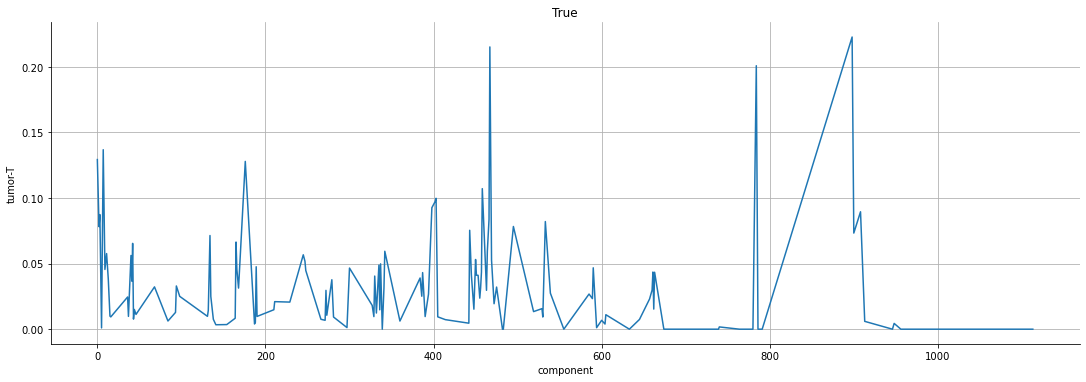

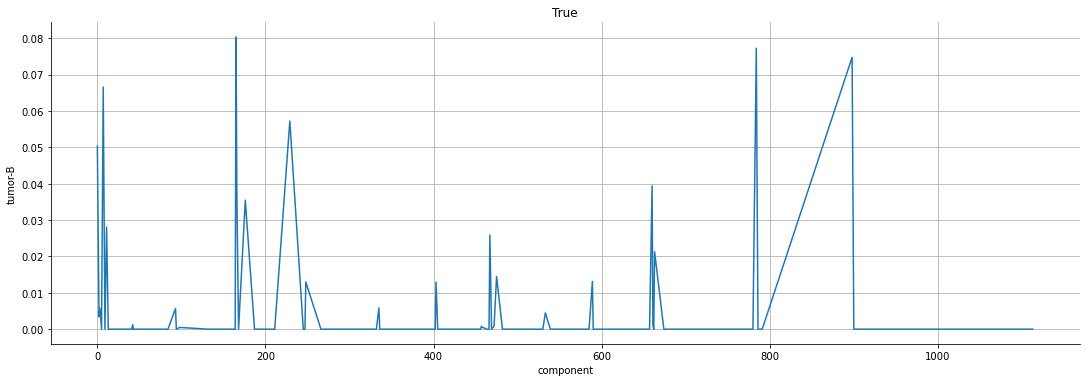

In [75]:
plot_relplot(edges_of_interest,'component','tumor-T','Reds','The of T-tumor edges across components',True)
plot_relplot(edges_of_interest,'component','tumor-B','Reds','The of B-tumor edges across components',True)
#plot_relplot(edges_of_interest,'component','tumor-NK','Reds','The of NK-tumor edges across components',True)

We can merge the total information about edge counting but here we will restric only to tumor vs (T, B, NK,..)

In [76]:
nodes = nodes.merge(edges_of_interest, on='component',how='left')

In [77]:
del edges_of_interest
del edge_phenotype_count_pivotted
del edge_phenotype_count

In [78]:
nodes = nodes.fillna(0)

In [79]:
nodes.component.unique()

array([   0,    7,    2,   11,    3,   16,    9,  248,  297,  300,  414,
        483,  482,  555,    5,   15,   13,   98,  189,  188,  247,  245,
        360,  633,  131,  138,  141,  190,  187,  210,  211,  495,  764,
        780,  791,   44,   40,   36,   41,   42,   37,  132,  645,  784,
         43,   46,  135,  134,  786,  657,  898,  913,  900,  908,  519,
        585,  948,  589,  663,  590,   68,  662,  661,  660, 1005,  946,
        956, 1020, 1007, 1013, 1031,  594,  676, 1113,   84,  154,  266,
        442,  443,  529,  600,  530,  674,  445,  604,  330,  327,  332,
        448,  450,  539,  735,  733,  739,  740,  273,  272,  271,  453,
        451,  457,  605,  329,  455,  456,  458,  533,   93,  164,  168,
        341,  336,  402,  384,  405,  466,  464,  386,  463,  472,  475,
        469,   94,  279,  335,  337,  398,  390,  394,  387,  342,  467,
        166,  281,  339,  403,  165,  229,  176])

## Plotting nodes

### Differentiating components

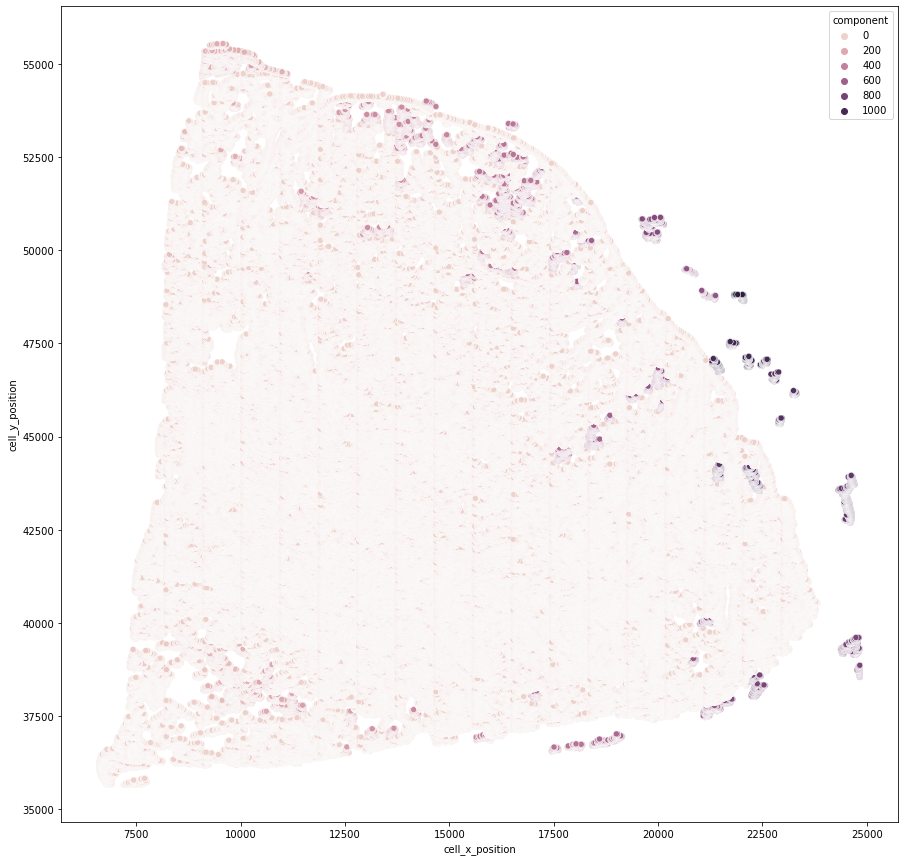

In [80]:
#vis_nodes = nodes

fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = nodes , x='cell_x_position', y= 'cell_y_position', hue = 'component').get_figure().savefig(PLOT_PATH+'scatter_component_250.png');

### Differentiating Tissue

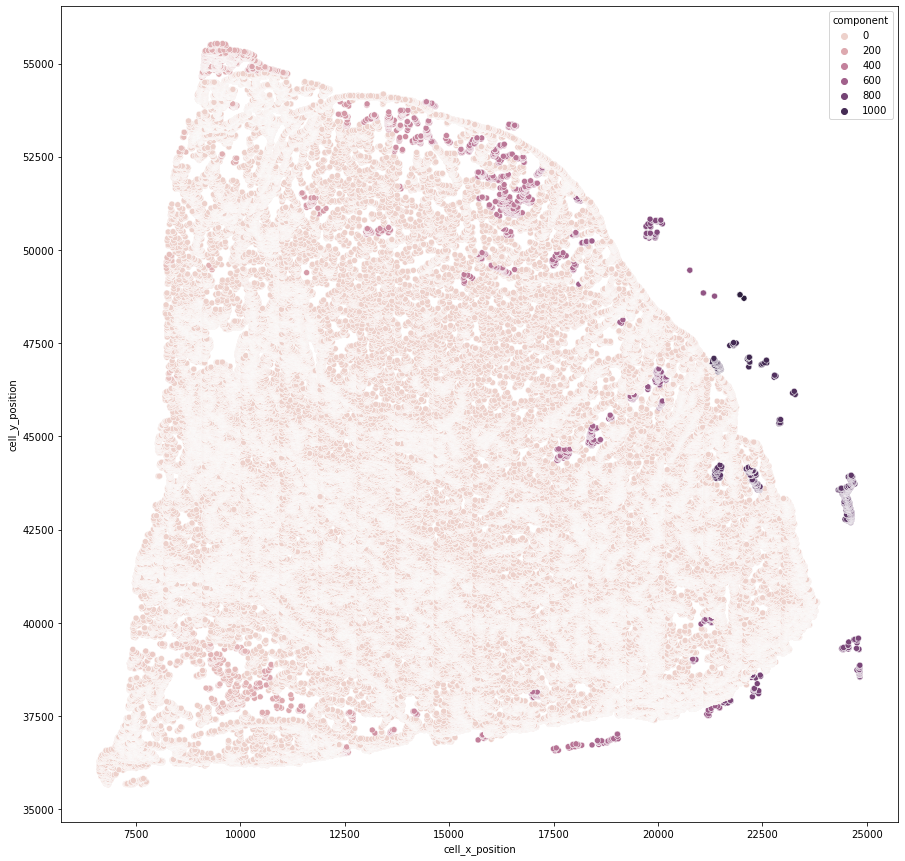

In [81]:
vis_nodes = nodes[(nodes.component != '') & (nodes.phenotype != 'stroma') & (nodes.phenotype != 'tumor') & (nodes.phenotype != 'MISSING') ]
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'component', cmap =sns.color_palette("tab10")).get_figure().savefig(PLOT_PATH+'scatter_only_components.png')

In [82]:
#vis_nodes = nodes[(nodes.phenotype != 'stroma')  & (nodes.phenotype != 'MISSING') ]
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype',
               # cmap =sns.color_palette("tab10")).get_figure().savefig(PLOT_PATH+'scatter_phenotype_no_stroma_no_tumor.png')

## plotting component graphs

### Structural plotting

In [83]:
MIN_NUMBER_PER__COMPONENT = 60
COMPONENT_NUM = 92
REMOVE_STROMA = False
BIPARTITE = False
SPATIAL = True
SAVE_FIG = True
FIG_NAME ='component_102_without_stroma_structural_plot'

In [84]:
#plot_component(cell_graph,PLOT_PATH,MIN_NUMBER_PER__COMPONENT,COMPONENT_NUM,
#            remove_stroma =REMOVE_STROMA,bipartite =BIPARTITE,
#              savefig=SAVE_FIG, figname=FIG_NAME)

### Spatial plotting

Text(0.5, 1.0, 'Spatial plot component 92')

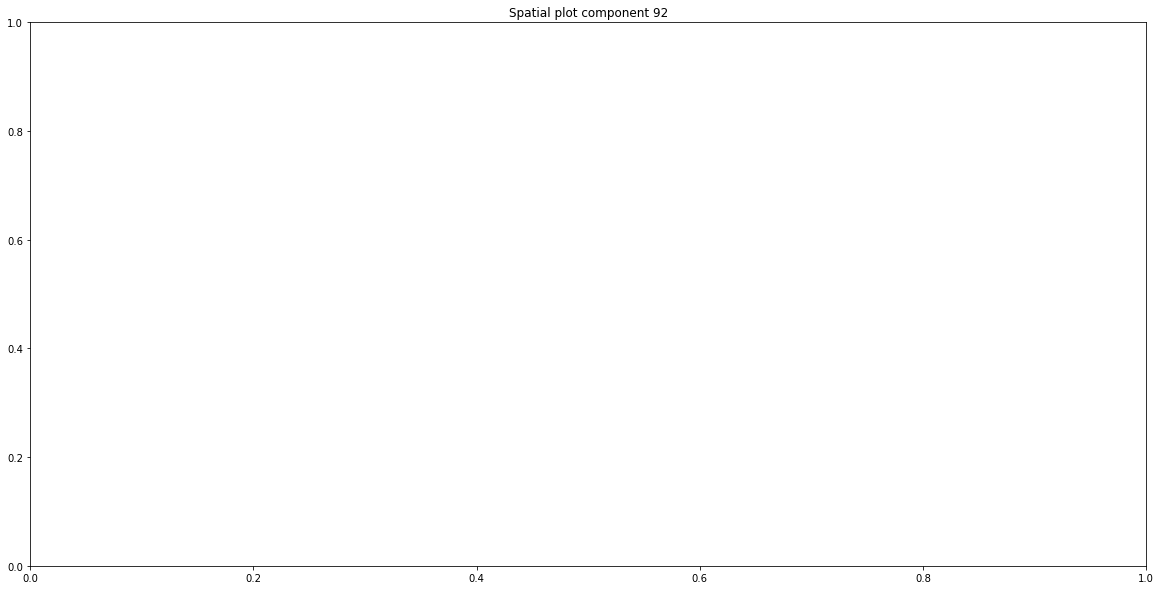

In [85]:
component = nodes[nodes.component == COMPONENT_NUM]
plt.figure(figsize=(20,10))
sns.scatterplot(data = component , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype' ,
                cmap =sns.color_palette("tab10")).get_figure().savefig(PLOT_PATH+' spatial_plot_component '+str(COMPONENT_NUM)+'.png')
plt.title('Spatial plot component '+str(COMPONENT_NUM))

## Component analysis

Since it is a bipartite graph, we are only considering the border

## Density analysis per component

In [86]:
phenotype_component_grouped = pd.DataFrame(nodes.groupby(['component','phenotype']).agg('count')['cell_id']).reset_index()

In [87]:
phenotype_component_grouped = phenotype_component_grouped.merge(size_df, on='component',how='left')

In [88]:
phenotype_component_grouped['pheno_ratio'] = phenotype_component_grouped['cell_id']/phenotype_component_grouped['size']

In [89]:
phenotype_component_pivotted = pd.pivot_table(phenotype_component_grouped, values='pheno_ratio', index=['component'],
                    columns=['phenotype'], aggfunc=np.sum)

phenotype_component_pivotted.columns.name = None

phenotype_component_pivotted = phenotype_component_pivotted.fillna(0).sort_values(['T']).reset_index()

In [90]:
phenotype_component_pivotted.head(5)

,component,B,MISSING,T,macrophages,stroma,tumor
0,1113,0.000000,0.015075,0.0,0.015075,0.969849,0.000000
1,1007,0.000000,0.000000,0.0,0.048077,0.951923,0.000000
2,956,0.017094,0.008547,0.0,0.017094,0.957265,0.000000
3,297,0.000000,0.057554,0.0,0.014388,0.302158,0.625899
4,339,0.000000,0.014706,0.0,0.014706,0.441176,0.529412


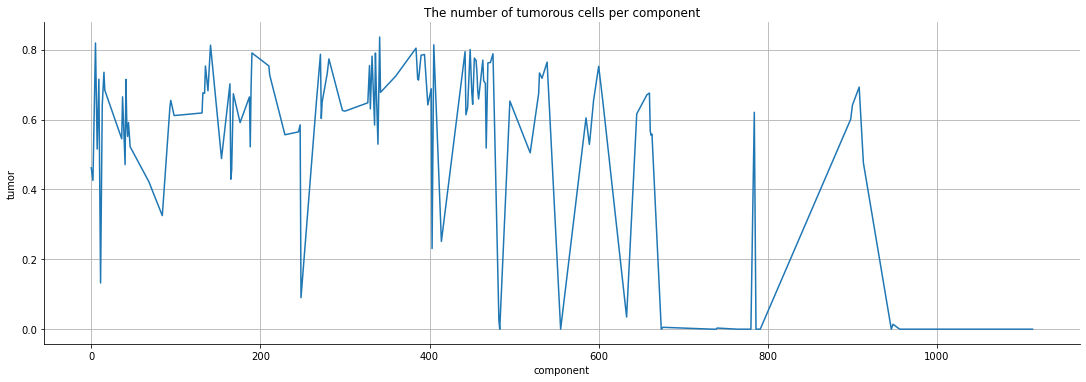

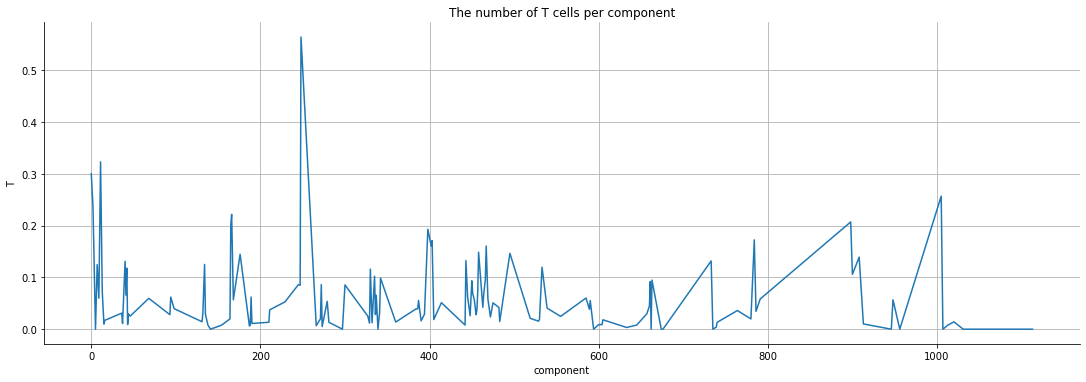

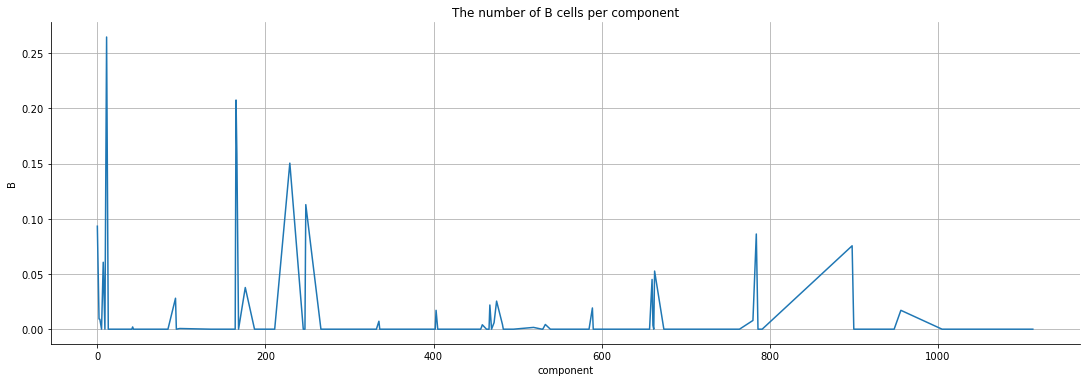

In [91]:
plot_relplot(phenotype_component_pivotted,'component','tumor',PLOT_PATH,'Reds','The number of tumorous cells per component',True)
plot_relplot(phenotype_component_pivotted,'component','T',PLOT_PATH,'Reds','The number of T cells per component',True)
plot_relplot(phenotype_component_pivotted,'component','B',PLOT_PATH,'Reds','The number of B cells per component',True)
#plot_relplot(phenotype_component_pivotted_copy,'component','NK',PLOT_PATH,'Reds','The number of NK cells per component',True)


In [92]:
phenotype_component_pivotted = phenotype_component_pivotted.merge(size_df, on='component',how='left')

The cells that are not associated to a component are out of border cells which means that they interacts only with similar tissue type cells : ***Stroma-Stroma / Tumor-Tumor***

We can use this component as a baseline, and compare the density of T_Cells/ B_Cells in each component in the border.

We will consider two types of densities, density subject to the total number of cells and density subject to tumorous cells

In [93]:
phenotype_component_pivotted = phenotype_component_pivotted[phenotype_component_pivotted.tumor != 0 ].copy()

In [94]:
phenotype_component_pivotted = phenotype_component_pivotted.rename(columns = {'size_x':'size'})

In [95]:
main_phenotypes = ['T','B','NK','stroma','tumor','dendtritic','macrophages']
columns = phenotype_component_pivotted.columns
for pheno in main_phenotypes:
    if not(pheno in columns):
        phenotype_component_pivotted[pheno] = 0

In [96]:
phenotype_component_pivotted['T_tumor_density'] = phenotype_component_pivotted['T']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['B_tumor_density'] = phenotype_component_pivotted['B']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['NK_tumor_density'] = phenotype_component_pivotted['NK']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['stroma_tumor_density'] = phenotype_component_pivotted['stroma']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['T_density'] = phenotype_component_pivotted['T']/phenotype_component_pivotted['size']
phenotype_component_pivotted['B_density'] = phenotype_component_pivotted['B']/phenotype_component_pivotted['size']
phenotype_component_pivotted['NK_density'] = phenotype_component_pivotted['NK']/phenotype_component_pivotted['size']
phenotype_component_pivotted['dendtritic_density'] = phenotype_component_pivotted['dendtritic']/phenotype_component_pivotted['size']
phenotype_component_pivotted['macrophages_density'] = phenotype_component_pivotted['macrophages']/phenotype_component_pivotted['size']


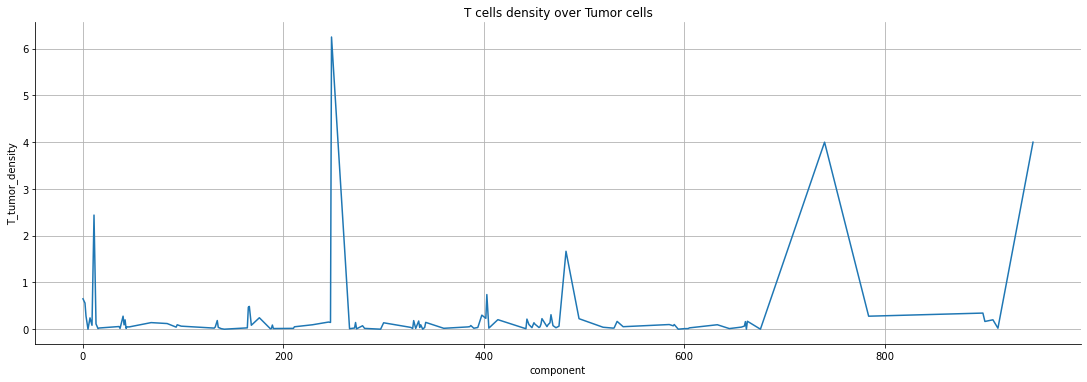

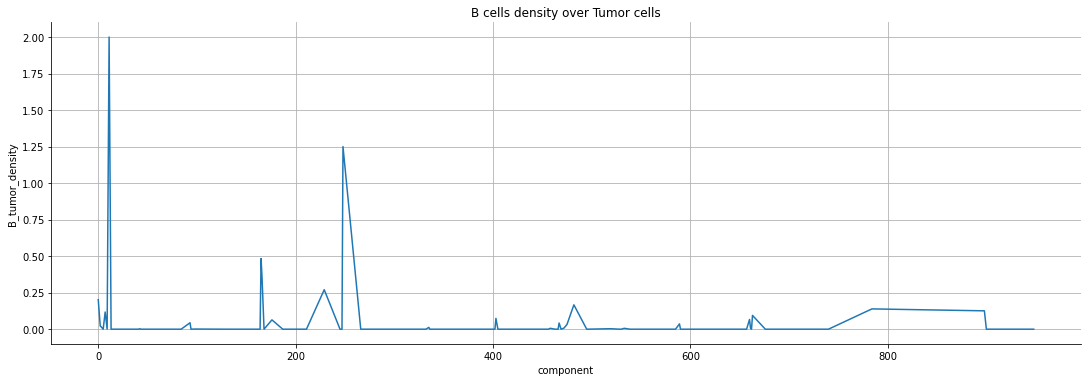

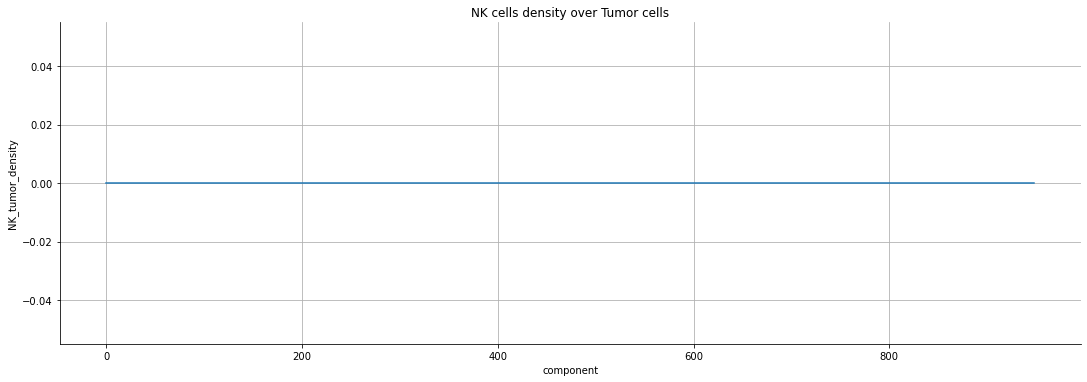

In [97]:
plot_relplot(phenotype_component_pivotted,'component','T_tumor_density',PLOT_PATH,'Reds','T cells density over Tumor cells',True)
plot_relplot(phenotype_component_pivotted,'component','B_tumor_density',PLOT_PATH,'Reds','B cells density over Tumor cells',True)
plot_relplot(phenotype_component_pivotted,'component','NK_tumor_density',PLOT_PATH,'Reds','NK cells density over Tumor cells',True)

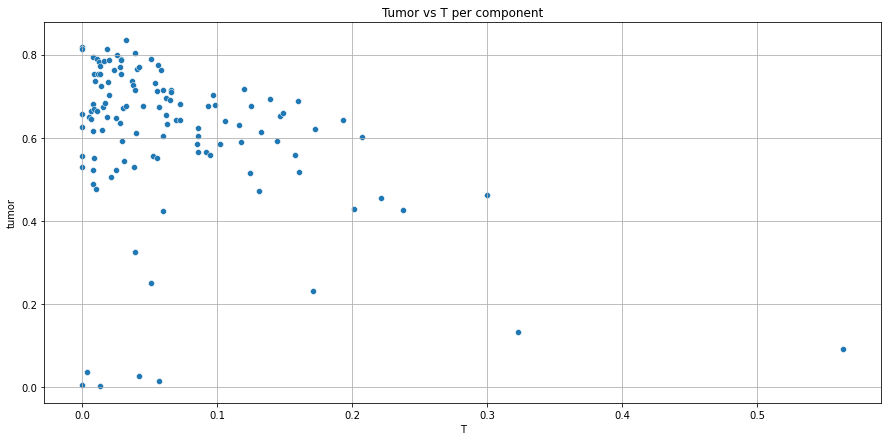

In [98]:
scatter_plot(phenotype_component_pivotted, 'T','tumor',PLOT_PATH,title ='Tumor vs T per component',savefig=False)

In [99]:
phenotype_component_pivotted.head(2)

,component,B,MISSING,T,macrophages,stroma,tumor,size,NK,dendtritic,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density,T_density,B_density,NK_density,dendtritic_density,macrophages_density
3,297,0.0,0.057554,0.0,0.014388,0.302158,0.625899,139,0,0,0.0,0.0,0.0,0.482759,0.0,0.0,0.0,0.0,0.000104
4,339,0.0,0.014706,0.0,0.014706,0.441176,0.529412,204,0,0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.000072


In [100]:
#plot_component(cell_graph,MIN_NUMBER_PER__COMPONENT,COMPONENT_NUM,
#              remove_stroma =REMOVE_STROMA,bipartite =BIPARTITE,
#              savefig=SAVE_FIG, figname=FIG_NAME)

In [101]:
nodes = nodes.merge(phenotype_component_pivotted, on='component', how='left')

In [102]:
del phenotype_component_pivotted
del phenotype_component_grouped

# High level Graph 

In [103]:
nodes.head(3)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border,tumor_degree,stroma_degree,missing_degree,total_degree,...,dendtritic,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density,T_density,B_density,NK_density,dendtritic_density,macrophages_density
0,1,6831.9,35658.2,tumor,MISSING,True,3.0,2.0,0.0,5.0,...,0.0,0.649869,0.201898,0.0,0.243455,0.000045,0.000014,0.0,0.0,0.000001
1,2,6846.7,35658.2,tumor,MISSING,True,3.0,0.0,0.0,3.0,...,0.0,0.649869,0.201898,0.0,0.243455,0.000045,0.000014,0.0,0.0,0.000001
2,3,6867.6,35659.2,tumor,tumor,True,11.0,0.0,0.0,11.0,...,0.0,0.649869,0.201898,0.0,0.243455,0.000045,0.000014,0.0,0.0,0.000001


## Aggregations

In [104]:
nodes.columns

Index(['cell_id', 'cell_x_position', 'cell_y_position', 'tissue_category',
       'phenotype', 'on_border', 'tumor_degree', 'stroma_degree',
       'missing_degree', 'total_degree', 'MISSING_degree',
       'tumor_pheno_degree', 'stroma_pheno_degree', 'macrophages_degree',
       'T_degree', 'B_degree', 'clustering_coef', 'component', 'size_x',
       'AUC_area', 'B-B', 'MISSING-B', 'MISSING-MISSING', 'T-B', 'T-MISSING',
       'T-T', 'macrophages-B', 'macrophages-MISSING', 'macrophages-T',
       'macrophages-macrophages', 'stroma-B', 'stroma-MISSING', 'stroma-T',
       'stroma-macrophages', 'stroma-stroma', 'tumor-B', 'tumor-MISSING',
       'tumor-T', 'tumor-macrophages', 'tumor-stroma', 'tumor-tumor', 'B',
       'MISSING', 'T', 'macrophages', 'stroma', 'tumor', 'size_y', 'NK',
       'dendtritic', 'T_tumor_density', 'B_tumor_density', 'NK_tumor_density',
       'stroma_tumor_density', 'T_density', 'B_density', 'NK_density',
       'dendtritic_density', 'macrophages_density'],
   

In [105]:
columns_to_avg = ['component','cell_x_position', 'cell_y_position', 'clustering_coef','missing_degree', 'stroma_degree', 'tumor_degree', 'total_degree',
       'B_degree', 'MISSING_degree', 'NK_degree', 'T_degree',
       'dendtritic_degree', 'macrophages_degree', 'tumor_pheno_degree', 'stroma_pheno_degree',
       'T','B', 'MISSING', 'NK', 'dendtritic', 'macrophages', 'stroma', 'tumor',
       'T_tumor_density', 'B_tumor_density', 'NK_tumor_density',
       'stroma_tumor_density', 'T_density', 'B_density', 'NK_density',
       'dendtritic_density', 'macrophages_density','AUC_area','B-B',
       'MISSING-B', 'MISSING-MISSING', 'T-B', 'T-MISSING', 'T-T',
       'dendtritic-B', 'dendtritic-MISSING', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-B', 'macrophages-MISSING',
       'macrophages-T', 'macrophages-dendtritic', 'macrophages-macrophages',
       'stroma-B', 'stroma-MISSING', 'stroma-T', 'stroma-dendtritic',
       'stroma-macrophages', 'stroma-stroma', 'tumor-B', 'tumor-MISSING',
       'tumor-T', 'tumor-dendtritic', 'tumor-macrophages', 'tumor-stroma',
       'tumor-tumor']

all_columns = nodes.columns

In [106]:
#nodes = add_null_column(nodes,columns_to_sum)
nodes_to_components = add_null_column(nodes,columns_to_avg)

In [107]:
#component_nodes_sum = nodes[columns_to_sum].groupby(['component']).agg('sum').reset_index()
component_nodes = nodes_to_components.groupby(['component']).agg('mean').reset_index()
#component_nodes = component_nodes_sum.merge(component_nodes_avg, on='component', how ='left')
component_nodes = component_nodes.drop(['cell_id','on_border'],axis =1)

In [108]:
component_nodes.tail()

,component,cell_x_position,cell_y_position,tumor_degree,stroma_degree,missing_degree,total_degree,MISSING_degree,tumor_pheno_degree,stroma_pheno_degree,...,macrophages_density,NK_degree,dendtritic_degree,dendtritic-B,dendtritic-MISSING,dendtritic-T,dendtritic-dendtritic,macrophages-dendtritic,stroma-dendtritic,tumor-dendtritic
134,1007,22182.030769,46936.603846,0.000000,9.413462,1.663462,11.076923,0.000000,0.0,10.471154,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,1013,22543.163492,46983.789683,0.000000,8.888889,1.063492,9.952381,0.000000,0.0,9.095238,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,1020,21779.104965,47477.668085,0.099291,11.354610,0.780142,12.234043,0.134752,0.0,10.992908,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,1031,22149.859483,47079.389655,0.000000,9.715517,0.931034,10.646552,0.000000,0.0,9.905172,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,1113,21964.460804,48757.775377,0.075377,11.321608,1.246231,12.643216,0.090452,0.0,12.422111,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
component_x = component_nodes.cell_x_position.values
component_y = component_nodes.cell_y_position.values
points = []
for x,y in zip(component_x,component_y):
    points.append([x,y])

points = np.array(points)    
tri = Delaunay(points)

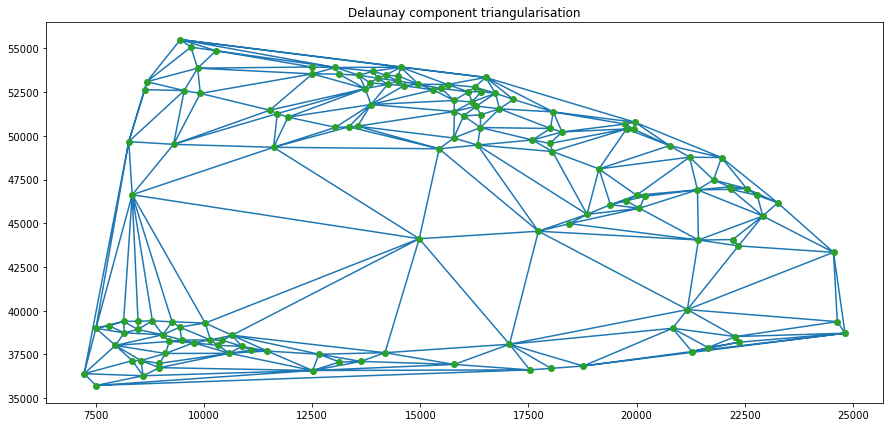

In [110]:
fig = plt.figure(figsize=(15,7))

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.title('Delaunay component triangularisation')    
plt.show()
fig.savefig(PLOT_PATH+'Delaunay_component_triangularisation.png')

In [111]:
threshold = 1000
vertices = component_nodes.component.values
coord, edges_component = get_high_level_graph(component_nodes,threshold)

In [112]:
len(vertices)

139

### Build graph

In [113]:
component_graph = nx.Graph() # for a directed graph use nx.DiGraph()

component_graph.add_nodes_from(range(len(vertices)))  # add multiple nodes at once

component_graph.add_edges_from(edges_component)

#visualize_component_graph(component_graph,k=0.05, alpha=0.8,savefig=True,figname='High_level_graph_threshold_200.png')


In [114]:
laplacian_matrix = nx.laplacian_matrix(component_graph).A
eigen_vals, eigen_vects = np.linalg.eig(laplacian_matrix)

In [115]:
idx = (-eigen_vals).argsort()[::-1]   
eigenValues = eigen_vals[idx]
eigenVectors = eigen_vects[:,idx]

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


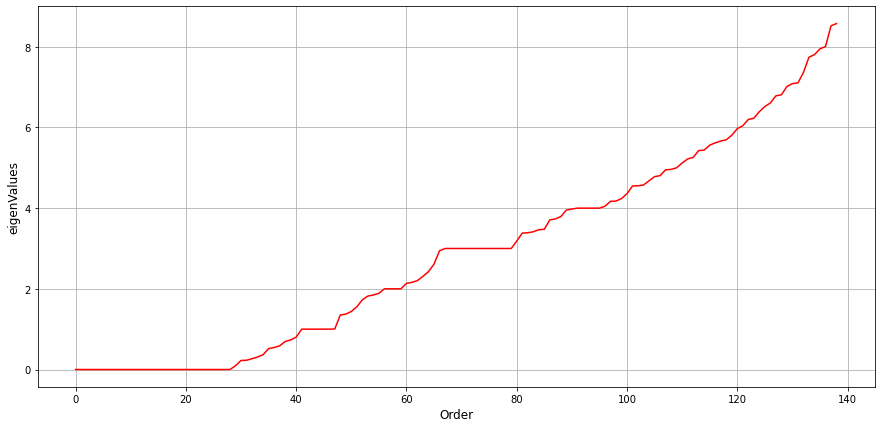

In [116]:
fig = plt.figure(figsize=(15,7))
plt.plot(eigenValues,color='r')
plt.grid()
plt.ylabel("eigenValues", size="large")
plt.xlabel("Order", size="large")

plt.title("", size="large")
plt.show();
fig.savefig(PLOT_PATH + 'T-Tumor edges count signal projection.png')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


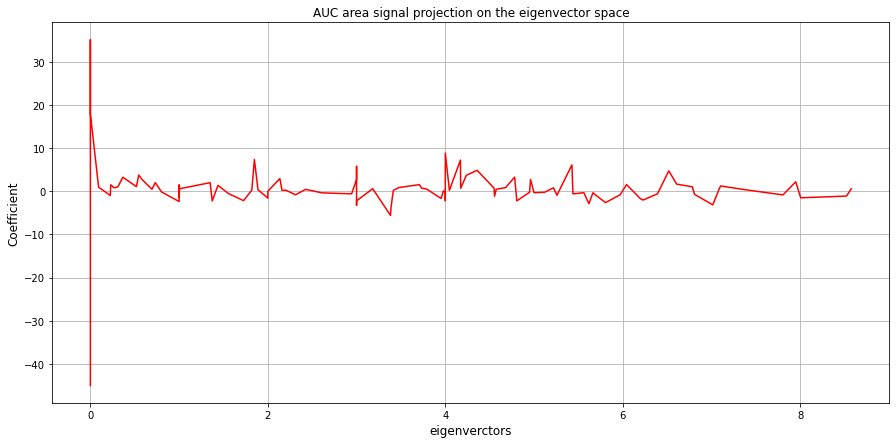

In [117]:
SIGNAL = np.array(component_nodes.AUC_area.fillna(0).values)
GRAPH = component_graph
FIGNAME = 'AUC area signal projection on the eigenvector space'
projection = project_signal(GRAPH,SIGNAL,PLOT_PATH,True,'b',True,FIGNAME)

## Quadratic laplacian forms

In [118]:
quadtratics = get_quadratic_laplacian_forms(component_nodes,vertices,edges_component)

In [119]:
quadtratics = pd.melt(quadtratics)

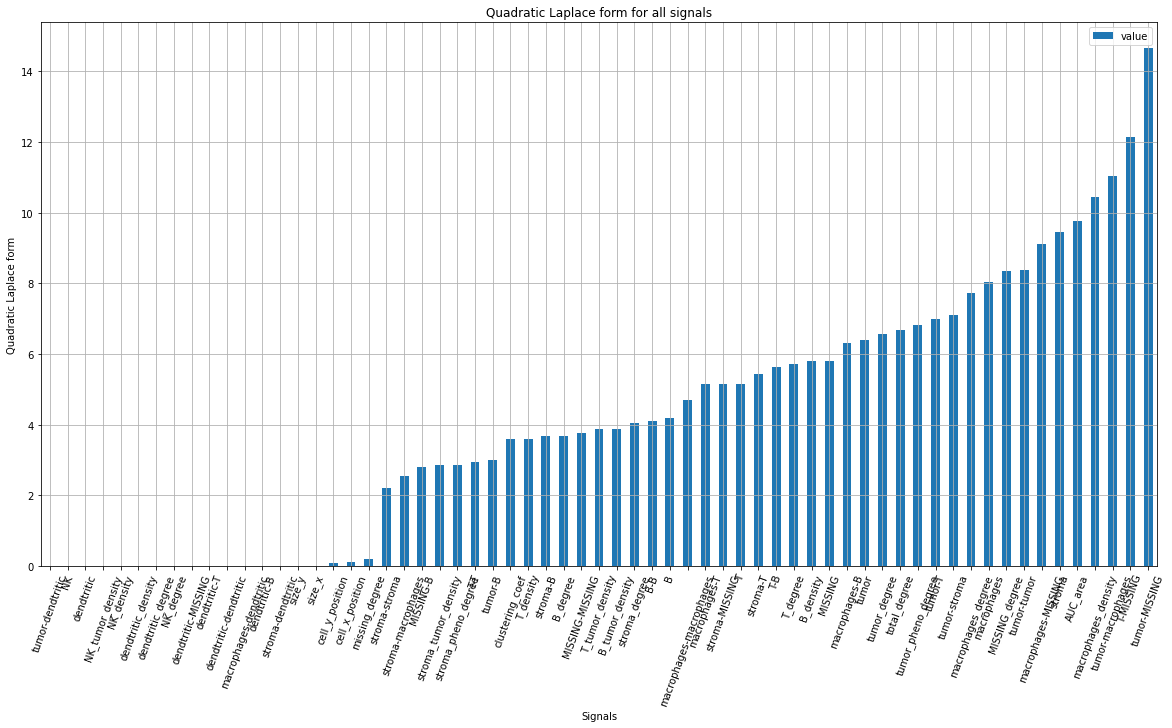

In [120]:
fig = quadtratics.sort_values(['value']).plot.bar(x='variable',y='value',rot=70,figsize =(20,10))
plt.xlabel('Signals')
plt.ylabel('Quadratic Laplace form')
plt.grid()
plt.title('Quadratic Laplace form for all signals')
plt.savefig(PLOT_PATH + 'Quadratic Laplace form for all signals.png')

In [121]:
nodes.to_csv(OUTPUT_PATH + 'nodes_features.csv', index = False)

In [122]:
component_nodes.to_csv(OUTPUT_PATH + 'component_features.csv', index = False)

In [123]:
get_quadratic_laplacian_forms(component_nodes,vertices,edges_component).to_csv(OUTPUT_PATH + 'laplace_quadratic_form_high_level_graph.csv', index = False)

In [124]:
nodes_stats.to_csv(OUTPUT_PATH + 'nodes_stats.csv', index = False)

In [125]:
len(edges)

5973804

In [126]:
edges.component.unique()

array([   0,    2,    3,    5,    7,    9,   11,   13,   15,   16,   36,
         37,   40,   41,   42,   43,   44,   46,   68,   84,   93,   94,
         98,  131,  132,  134,  135,  138,  141,  154,  164,  165,  166,
        168,  176,  187,  188,  189,  190,  210,  211,  229,  245,  247,
        248,  266,  271,  272,  273,  279,  281,  297,  300,  327,  329,
        330,  332,  335,  336,  337,  339,  341,  342,  360,  384,  386,
        387,  390,  394,  398,  402,  403,  405,  414,  442,  443,  445,
        448,  450,  451,  453,  455,  456,  457,  458,  463,  464,  466,
        467,  469,  472,  475,  482,  483,  495,  519,  529,  530,  533,
        539,  555,  585,  589,  590,  594,  600,  604,  605,  633,  645,
        657,  660,  661,  662,  663,  674,  676,  733,  735,  739,  740,
        764,  780,  784,  786,  791,  898,  900,  908,  913,  946,  948,
        956, 1005, 1007, 1013, 1020, 1031, 1113])